# COVID-19 Time Series Forecasting with Neural Networks
This notebook demonstrates a complete pipeline for forecasting COVID-19 daily confirmed cases using time series analysis and neural network models. The approach includes data preprocessing, feature engineering with HP and CF filters, model training with MLflow tracking, and comprehensive evaluation.

## 1. Configuration and Setup
### 1.1 Import Dependencies


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import torch
import mlflow
import mlflow.pytorch
from mlflow import MlflowClient
from mlflow.entities import ViewType
from pathlib import Path
import warnings
from oceanwave_forecast import training

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2 Global Configuration


In [41]:
# Data Configuration
DATA_CONFIG = {
    'csv_path': "D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\COVID_19_until_2021_02_01.csv",
    'countries': ["Italy", "Russia", "Hungary", "Austria", "Israel", "Poland"],
    'target_country': ['Russia','Poland'],  # For evaluation
    'date_column': 'Date',
    'target_column': 'Confirmed'
}

# Model Configuration
MODEL_CONFIG = {
    'window': 150,
    'horizon': 60,
    'val_split': 0.2,
    'hidden_size': 64,
    'hidden_fc': 64,
    'teacher_ratio': 0.5,
    'lr': 0.001,
    'epochs': 1000
}

# MLflow Configuration
MLFLOW_CONFIG = {
    'experiment_name': "COVID_simple_model",
    'run_number': 8,
    'tags': {
        'project': 'covid',
        'model_type': 'neural_network',
        'data_source': 'covid_19_until_2021_02_01'
    }
}

# Visualization Configuration
VIZ_CONFIG = {
    'figure_size': (12, 8),
    'date_format': "%Y-%m-%d",
    'date_interval': 90,
    'line_width': 1.5,
    'grid_alpha': 0.3
}

print("✅ Configuration loaded successfully")

✅ Configuration loaded successfully


## 2. Data Loading and Preprocessing

In [32]:
def load_and_preprocess_data(csv_path: str, date_column: str, target_column: str) -> pd.DataFrame:
    """
    Load COVID-19 data and perform initial preprocessing.
    
    Args:
        csv_path (str): Path to the CSV file
        date_column (str): Name of the date column
        target_column (str): Name of the target variable column
    
    Returns:
        pd.DataFrame: Preprocessed dataframe with parsed dates
    """
    try:
        df = pd.read_csv(csv_path, parse_dates=[date_column])
        print(f"✅ Data loaded successfully: {df.shape}")
        print(f"   Date range: {df[date_column].min()} to {df[date_column].max()}")
        print(f"   Countries: {df['Country'].nunique()}")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        raise

def extract_country_data(df: pd.DataFrame, country: str, target_column: str) -> tuple:
    """
    Extract and process data for a specific country.
    
    Args:
        df (pd.DataFrame): Input dataframe
        country (str): Country name
        target_column (str): Target variable column name
    
    Returns:
        tuple: (dates, daily_differences, normalized_series)
    """
    country_df = df[df["Country"] == country].sort_values("Date").reset_index(drop=True)
    
    if country_df.empty:
        raise ValueError(f"No data found for country: {country}")
    
    dates = country_df["Date"].values
    daily_diffs = country_df[target_column].diff().fillna(0).values
    
    # Normalize to [0, 1] range
    max_value = daily_diffs.max()
    normalized_series = daily_diffs / max_value if max_value > 0 else daily_diffs
    
    print(f"✅ {country} data extracted: {len(dates)} data points")
    return dates, daily_diffs, normalized_series

# Load the main dataset
df = load_and_preprocess_data(
    DATA_CONFIG['csv_path'], 
    DATA_CONFIG['date_column'], 
    DATA_CONFIG['target_column']
)

✅ Data loaded successfully: (103400, 6)
   Date range: 2020-01-22 00:00:00 to 2021-01-31 00:00:00
   Countries: 192


## 3. Exploratory Data Analysis
### 3.1 Single Country Analysis


✅ Austria data extracted: 376 data points


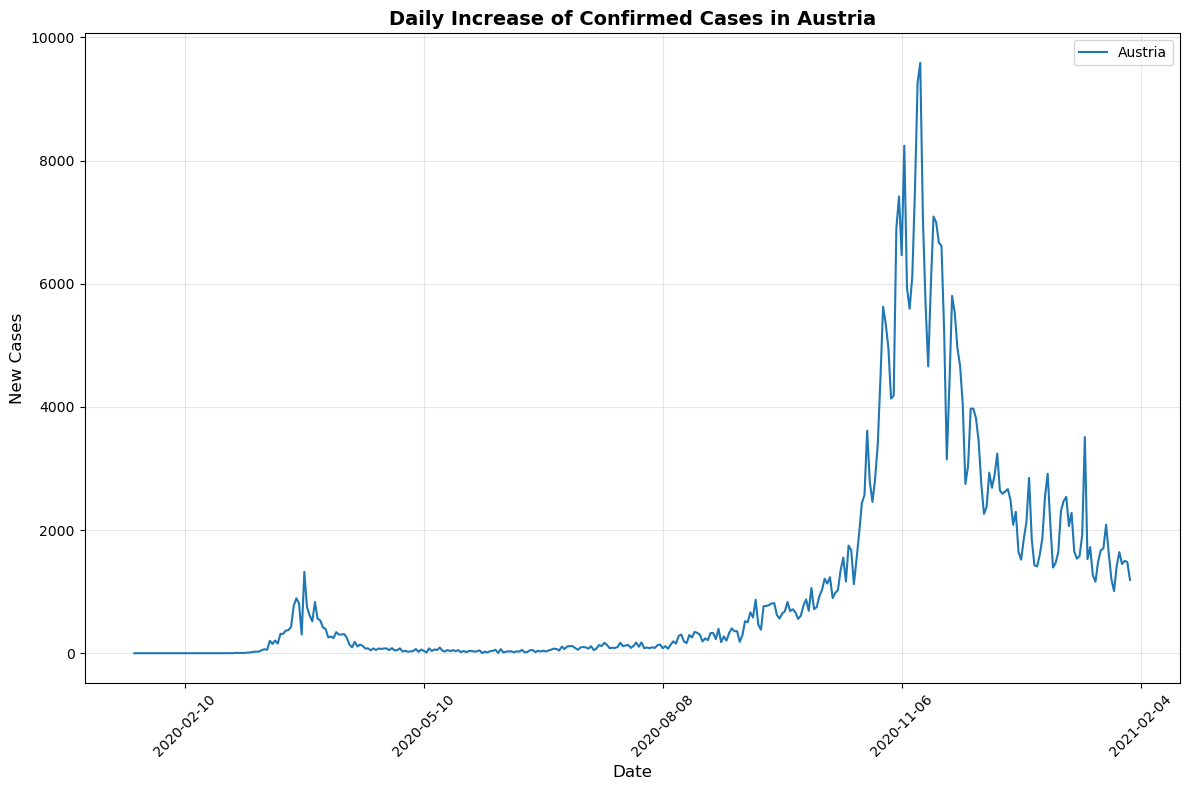

In [33]:
def plot_single_country_analysis(df: pd.DataFrame, country: str, target_column: str):
    """
    Plot daily increase analysis for a single country.
    
    Args:
        df (pd.DataFrame): Input dataframe
        country (str): Country name to analyze
        target_column (str): Target variable column name
    """
    dates, daily_diffs, _ = extract_country_data(df, country, target_column)
    
    plt.figure(figsize=VIZ_CONFIG['figure_size'])
    plt.plot(dates, daily_diffs, label=country, linewidth=VIZ_CONFIG['line_width'])
    
    plt.title(f"Daily Increase of Confirmed Cases in {country}", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("New Cases", fontsize=12)
    
    # Format date ticks
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(VIZ_CONFIG['date_format']))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=VIZ_CONFIG['date_interval']))
    plt.xticks(rotation=45)
    
    plt.grid(True, alpha=VIZ_CONFIG['grid_alpha'])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Analyze Austria as example
plot_single_country_analysis(df, "Austria", DATA_CONFIG['target_column'])

### 3.2 Multi-Country Comparative Analysis


✅ Italy data extracted: 376 data points
✅ Russia data extracted: 376 data points
✅ Hungary data extracted: 376 data points
✅ Austria data extracted: 376 data points
✅ Israel data extracted: 376 data points
✅ Poland data extracted: 376 data points


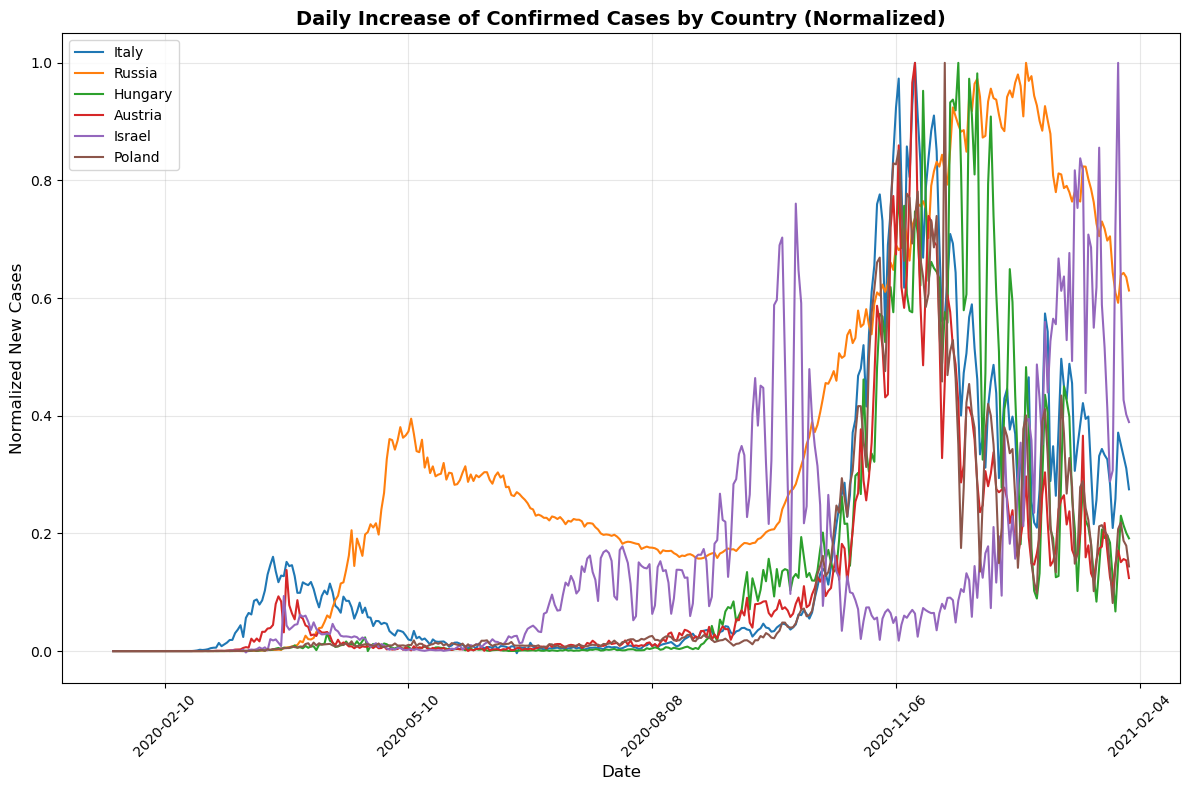

In [43]:
def plot_multi_country_analysis(df: pd.DataFrame, countries: list, target_column: str):
    """
    Plot normalized daily increases for multiple countries.
    
    Args:
        df (pd.DataFrame): Input dataframe
        countries (list): List of country names
        target_column (str): Target variable column name
    """
    plt.figure(figsize=VIZ_CONFIG['figure_size'])
    
    # Setup date formatting
    locator = mdates.DayLocator(interval=VIZ_CONFIG['date_interval'])
    formatter = mdates.DateFormatter(VIZ_CONFIG['date_format'])
    
    for country in countries:
        try:
            dates, _, normalized_series = extract_country_data(df, country, target_column)
            plt.plot(dates, normalized_series, label=country, linewidth=VIZ_CONFIG['line_width'])
        except ValueError as e:
            print(f"⚠️  Warning: {e}")
            continue
    
    plt.title("Daily Increase of Confirmed Cases by Country (Normalized)", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Normalized New Cases", fontsize=12)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    
    plt.legend()
    plt.grid(True, alpha=VIZ_CONFIG['grid_alpha'])
    plt.tight_layout()
    plt.show()

# Analyze all configured countries
plot_multi_country_analysis(df, DATA_CONFIG['countries'], DATA_CONFIG['target_column'])

## 4. Feature Engineering
### 4.1 Time Series Decomposition

✅ Italy data extracted: 376 data points
✅ Russia data extracted: 376 data points
✅ Hungary data extracted: 376 data points
✅ Austria data extracted: 376 data points
✅ Israel data extracted: 376 data points
✅ Poland data extracted: 376 data points


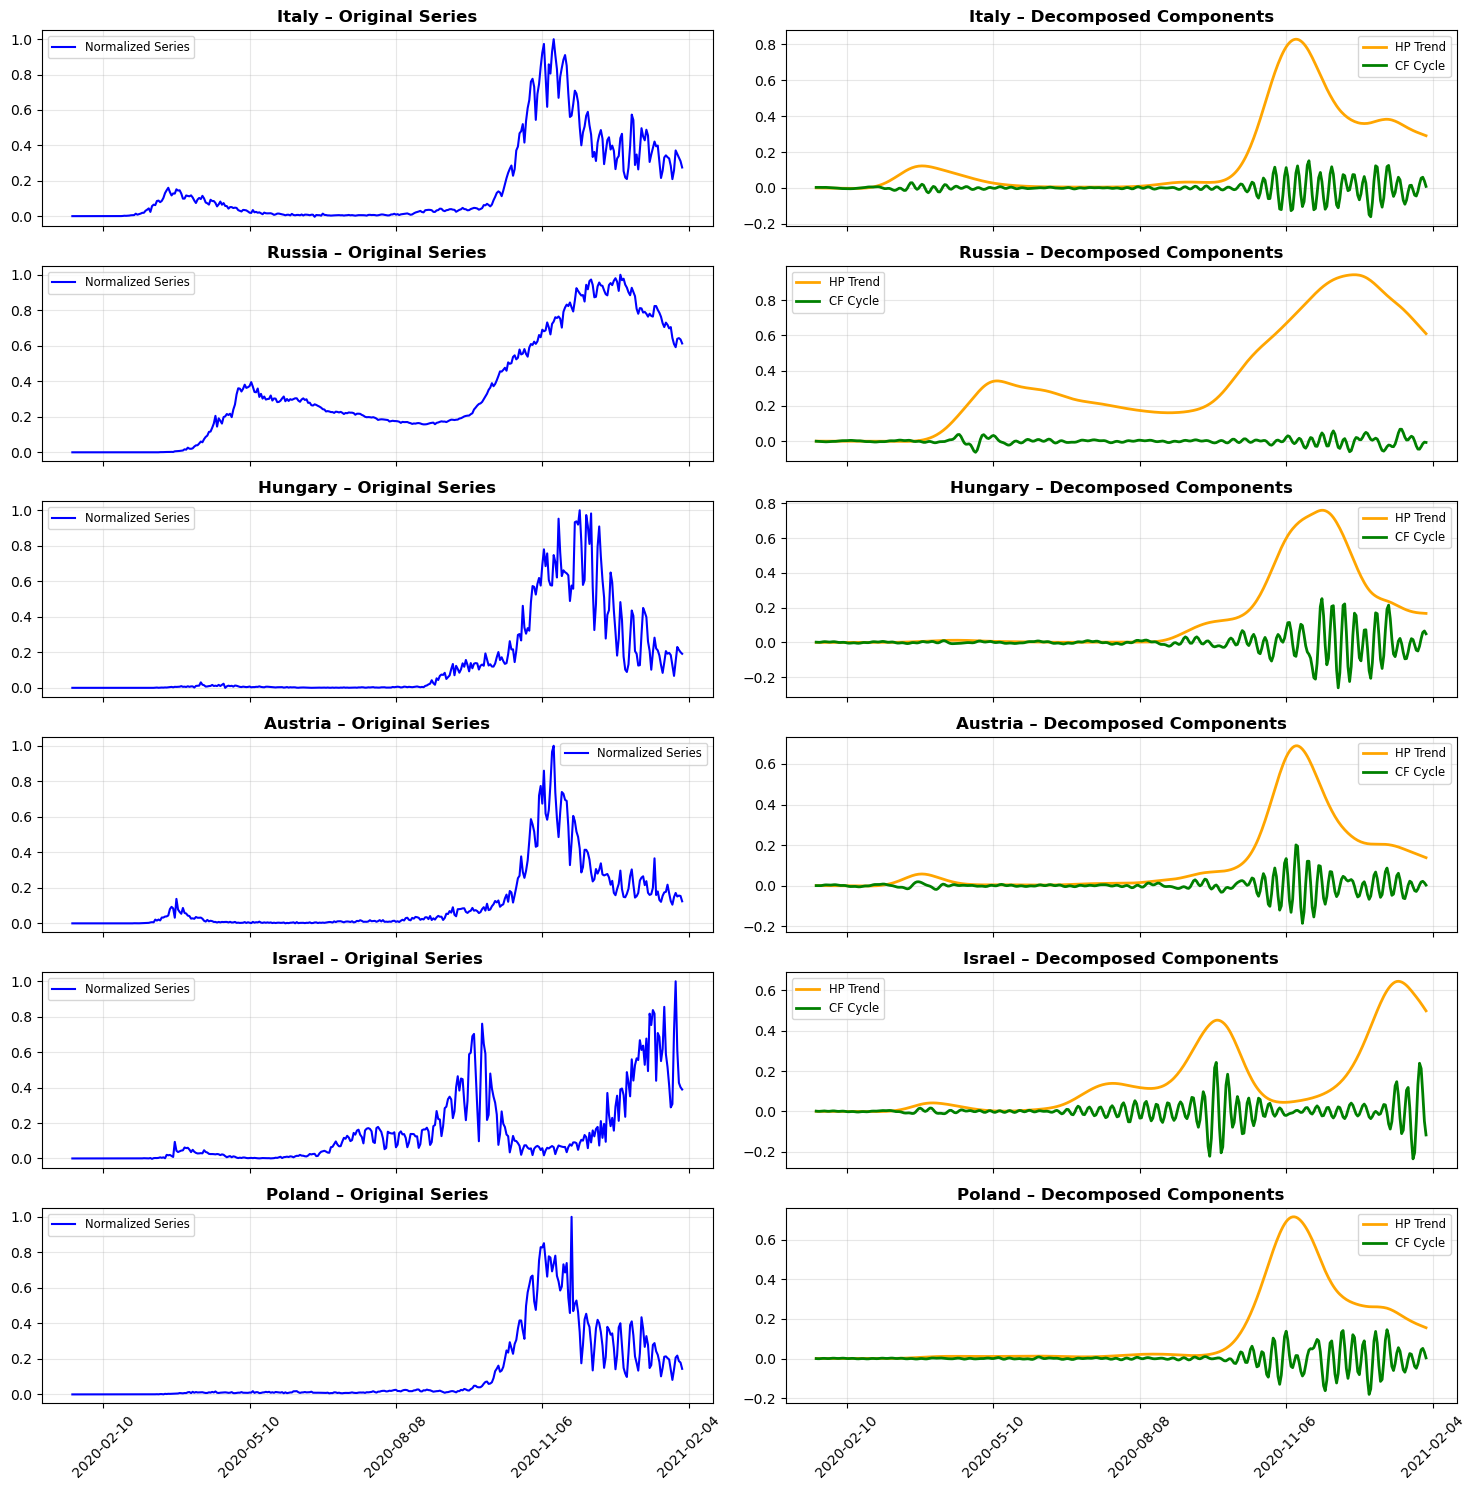

In [35]:
def compute_time_series_features(time_series: np.ndarray) -> tuple:
    """
    Compute HP trend and CF cycle components for time series.
    
    Args:
        time_series (np.ndarray): Input time series
    
    Returns:
        tuple: (hp_cycle, hp_trend, cf_cycle)
    """
    try:
        hp_cycle, hp_trend = sm.tsa.filters.hpfilter(time_series)
        cf_cycle, _ = sm.tsa.filters.cffilter(time_series)
        return hp_cycle, hp_trend, cf_cycle
    except Exception as e:
        print(f"❌ Error computing features: {e}")
        raise

def create_feature_matrix(time_series: np.ndarray, hp_trend: np.ndarray, cf_cycle: np.ndarray) -> list:
    """
    Create feature matrix combining original series with decomposed components.
    
    Args:
        time_series (np.ndarray): Original time series
        hp_trend (np.ndarray): HP filter trend component
        cf_cycle (np.ndarray): CF filter cycle component
    
    Returns:
        list: Feature matrix with combined features
    """
    feature_matrix = []
    for i in range(len(time_series)):
        feature_matrix.append([time_series[i], hp_trend[i], cf_cycle[i]])
    return feature_matrix

def plot_feature_decomposition(df: pd.DataFrame, countries: list, target_column: str):
    """
    Plot original series alongside HP trend and CF cycle components.
    
    Args:
        df (pd.DataFrame): Input dataframe
        countries (list): List of countries to analyze
        target_column (str): Target variable column name
    """
    countries_count = len(countries)
    fig, axes = plt.subplots(countries_count, 2, figsize=(15, 2.5 * countries_count), 
                            sharex="col", squeeze=False)
    
    # Common date formatting
    locator = mdates.DayLocator(interval=VIZ_CONFIG['date_interval'])
    formatter = mdates.DateFormatter(VIZ_CONFIG['date_format'])
    
    for i, country in enumerate(countries):
        try:
            dates, _, normalized_series = extract_country_data(df, country, target_column)
            hp_cycle, hp_trend, cf_cycle = compute_time_series_features(normalized_series)
            
            # Left panel: Original series
            ax0 = axes[i, 0]
            ax0.plot(dates, normalized_series, label="Normalized Series", color='blue')
            ax0.set_title(f"{country} – Original Series", fontweight='bold')
            ax0.grid(True, alpha=VIZ_CONFIG['grid_alpha'])
            ax0.legend(fontsize='small')
            ax0.xaxis.set_major_locator(locator)
            ax0.xaxis.set_major_formatter(formatter)
            ax0.tick_params(axis="x", rotation=45)
            
            # Right panel: HP trend & CF cycle
            ax1 = axes[i, 1]
            ax1.plot(dates, hp_trend, color="orange", label="HP Trend", linewidth=2)
            ax1.plot(dates, cf_cycle, color="green", label="CF Cycle", linewidth=2)
            ax1.set_title(f"{country} – Decomposed Components", fontweight='bold')
            ax1.grid(True, alpha=VIZ_CONFIG['grid_alpha'])
            ax1.legend(fontsize='small')
            ax1.xaxis.set_major_locator(locator)
            ax1.xaxis.set_major_formatter(formatter)
            ax1.tick_params(axis="x", rotation=45)
            
        except Exception as e:
            print(f"⚠️  Error processing {country}: {e}")
    
    plt.tight_layout()
    plt.show()

# Generate feature decomposition plots
plot_feature_decomposition(df, DATA_CONFIG['countries'], DATA_CONFIG['target_column'])

## 5. MLflow Experiment Management
### 5.1 Experiment Setup Module


In [36]:
def get_or_create_experiment(name: str, tags: dict) -> mlflow.entities.Experiment:
    """
    Return an experiment whose name matches and create if it doesn't exist.
    
    Args:
        name (str): Experiment name
        tags (dict): Tags to associate with experiment
    
    Returns:
        mlflow.entities.Experiment: MLflow experiment object
    """
    exp_list = mlflow.search_experiments(
        filter_string=f"name LIKE '{name}%'",
        view_type=ViewType.ALL,
    )
    
    # Try exact match on name
    for exp in exp_list:
        if exp.name == name:
            print(f"✅ Found existing experiment: {name}")
            return exp
    
    # Create new experiment with unique name
    suffix = 1
    candidate_name = name
    existing_names = {e.name for e in exp_list}
    while candidate_name in existing_names:
        suffix += 1
        candidate_name = f"{name}_{suffix}"
    
    exp_id = mlflow.create_experiment(candidate_name, tags=tags)
    print(f"✅ Created new experiment: {candidate_name}")
    return mlflow.get_experiment(exp_id)

def check_existing_run(experiment_id: str, run_number: int):
    """
    Check if a run with the same run_number already exists and is finished.
    
    Args:
        experiment_id (str): MLflow experiment ID
        run_number (int): Run number to check
    
    Returns:
        tuple: (run_exists, run_object)
    """
    existing_runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        filter_string=f"params.run_number = '{run_number}'",
        run_view_type=ViewType.ALL,
        output_format="list",
        max_results=1,
    )
    
    if existing_runs and existing_runs[0].info.status == "FINISHED":
        return True, existing_runs[0]
    elif existing_runs:
        return False, existing_runs[0]
    else:
        return False, None

# Setup MLflow experiment
exp = get_or_create_experiment(MLFLOW_CONFIG['experiment_name'], MLFLOW_CONFIG['tags'])

✅ Found existing experiment: COVID_simple_model


### 5.2 Model Training Pipeline


In [37]:
def run_training_pipeline():
    """
    Execute the complete model training pipeline with MLflow tracking.
    """
    run_exists, existing_run = check_existing_run(exp.experiment_id, MLFLOW_CONFIG['run_number'])
    
    if run_exists:
        print(f"🟢 Finished run already logged (id={existing_run.info.run_id}) – skipping.")
        return existing_run
    
    resume_id = existing_run.info.run_id if existing_run else None
    
    with mlflow.start_run(
        experiment_id=exp.experiment_id,
        run_name=f"run_{MLFLOW_CONFIG['run_number']:03d}",
        run_id=resume_id,
    ) as run:
        
        # Log parameters only once
        if not run.data.params:
            mlflow.log_param("run_number", MLFLOW_CONFIG['run_number'])
            mlflow.log_params({k: v for k, v in MODEL_CONFIG.items()})
            mlflow.log_param("countries", ",".join(DATA_CONFIG['countries']))
            mlflow.log_params(MLFLOW_CONFIG['tags'])
        
        print("🔄 Starting model training...")
        
        best_val, best_model = training.train_once(DATA_CONFIG, MODEL_CONFIG)
        mlflow.log_metric("best_val_mse", best_val)
        
        # Save model checkpoint
        ckpt = Path("best_model.pth")
        torch.save(best_model.state_dict(), ckpt)
        mlflow.log_artifact(str(ckpt))
        mlflow.pytorch.log_model(best_model, artifact_path="model")
        
        print("✅ Training pipeline completed")
    
    return run

# Execute training pipeline
training_run = run_training_pipeline()

🔄 Starting model training...
Loaded DataFrame → rows = 103400, unique countries = 192
[Italy] raw diffs → ts.shape = (375,)
[Italy] feature matrix → feats.shape = (375, 3)
[Italy] sliding_window → X_c.shape = (166, 150, 3); Y_c.shape = (166, 60, 3)
[Russia] raw diffs → ts.shape = (375,)
[Russia] feature matrix → feats.shape = (375, 3)
[Russia] sliding_window → X_c.shape = (166, 150, 3); Y_c.shape = (166, 60, 3)
[Hungary] raw diffs → ts.shape = (375,)
[Hungary] feature matrix → feats.shape = (375, 3)
[Hungary] sliding_window → X_c.shape = (166, 150, 3); Y_c.shape = (166, 60, 3)
[Austria] raw diffs → ts.shape = (375,)
[Austria] feature matrix → feats.shape = (375, 3)
[Austria] sliding_window → X_c.shape = (166, 150, 3); Y_c.shape = (166, 60, 3)
[Israel] raw diffs → ts.shape = (375,)
[Israel] feature matrix → feats.shape = (375, 3)
[Israel] sliding_window → X_c.shape = (166, 150, 3); Y_c.shape = (166, 60, 3)
[Poland] raw diffs → ts.shape = (375,)
[Poland] feature matrix → feats.shape = (3

2025/06/05 20:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Training pipeline completed


### 5.3 Experiment Monitoring

In [38]:
def print_experiment_tree(experiments: list):
    """
    Print a tree view of experiments and their runs.
    
    Args:
        experiments (list): List of MLflow experiments
    """
    def _print_tree(run, children_map, level=0):
        pad = "  " * level
        name = run.data.tags.get("mlflow.runName", "")
        print(f"{pad}• {name or run.info.run_id} "
              f"(run_id={run.info.run_id}, status={run.info.status})")
        for child in children_map.get(run.info.run_id, []):
            _print_tree(child, children_map, level + 1)
    
    for exp in experiments:
        print(f"\n=== Experiment: {exp.name} (id={exp.experiment_id}) ===")
        
        runs = mlflow.search_runs(
            experiment_ids=[exp.experiment_id],
            run_view_type=ViewType.ALL,
            output_format="list",
            max_results=100_000,
        )
        
        # Build parent → children map
        children_map, roots = {}, []
        for r in runs:
            parent = r.data.tags.get("mlflow.parentRunId")
            if parent:
                children_map.setdefault(parent, []).append(r)
            else:
                roots.append(r)
        
        # Print tree structure
        for r in roots:
            _print_tree(r, children_map)

def monitor_experiments():
    """
    Monitor and display all COVID project experiments.
    """
    TAG_KEY, TAG_VALUE = "project", "covid"
    
    experiments = mlflow.search_experiments(
        view_type=ViewType.ALL,
        filter_string=f"tags.{TAG_KEY} = '{TAG_VALUE}'",
    )
    
    print(f"📊 Found {len(experiments)} experiments with tag {TAG_KEY}={TAG_VALUE}")
    print_experiment_tree(experiments)

# Monitor experiments
monitor_experiments()

📊 Found 1 experiments with tag project=covid

=== Experiment: COVID_simple_model (id=240533425331854824) ===
• run_008 (run_id=eb5447feec784a02b668a38a2f44ba92, status=FINISHED)
• run_006 (run_id=1f83dcb9056d406eb8666f80ae854eb8, status=FINISHED)
• run_004 (run_id=5e40ec1e95c944a6a4c75f0d050be05c, status=FINISHED)
• run_003 (run_id=7413b01ba84e46a09ba1eeead2648e60, status=FINISHED)
• run_002 (run_id=8a3e10e93b94485db13193115cca3a47, status=FINISHED)
• run_001 (run_id=9d2e15d865d8415fa436fee8497138bd, status=FINISHED)


## 6. Model Analysis and Evaluation
### 6.1 Run Analysis Module


✅ Selected run_id = eb5447feec784a02b668a38a2f44ba92

📊 RUN ANALYSIS

=== Parameters ===
countries        Italy,Russia,Hungary,Austria,Israel,Poland
data_source                       covid_19_until_2021_02_01
epochs                                                 1000
hidden_fc                                                64
hidden_size                                              64
horizon                                                  60
lr                                                    0.001
model_type                                   neural_network
project                                               covid
run_number                                                8
teacher_ratio                                           0.5
val_split                                               0.2
window                                                  150

=== Tags ===
mlflow.log-model.history    [{"run_id": "eb5447feec784a02b668a38a2f44ba92"...
mlflow.runName                         

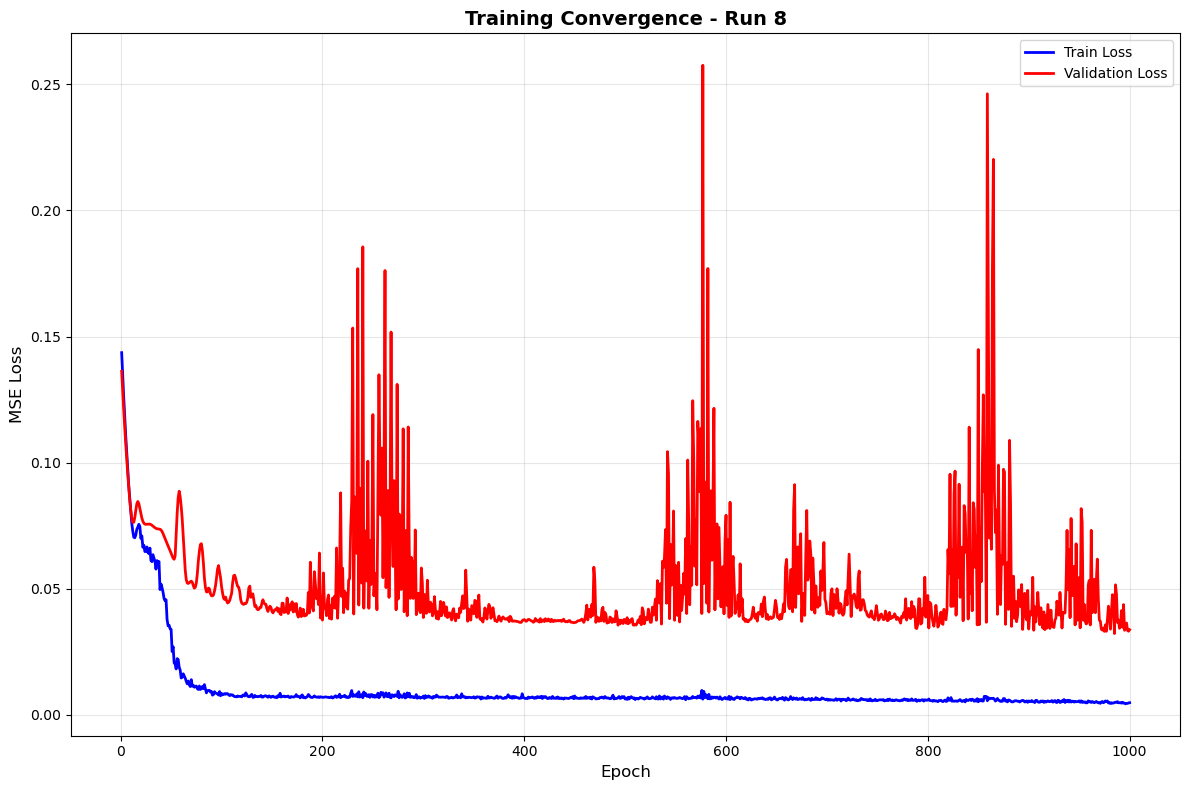

In [39]:
def get_specific_run(experiment_name: str, run_number: int):
    """
    Retrieve a specific run by experiment name and run number.
    
    Args:
        experiment_name (str): Name of the experiment
        run_number (int): Run number to retrieve
    
    Returns:
        tuple: (client, run_object, run_id)
    """
    client = MlflowClient()
    
    try:
        exp = client.get_experiment_by_name(experiment_name)
        if not exp:
            raise ValueError(f"Experiment '{experiment_name}' not found")
        
        runs = client.search_runs(
            exp.experiment_id,
            filter_string=f"params.run_number = '{run_number}'",
            order_by=["attribute.start_time DESC"],
            max_results=1
        )
        
        if len(runs) != 1:
            raise ValueError(f"Expected exactly one run, but got {len(runs)}")
        
        run = runs[0]
        run_id = run.info.run_id
        
        print(f"✅ Selected run_id = {run_id}")
        return client, run, run_id
        
    except Exception as e:
        print(f"❌ Error retrieving run: {e}")
        raise

def analyze_run_details(client, run, run_id):
    """
    Analyze and display run details including parameters, metrics, and artifacts.
    
    Args:
        client: MLflow client
        run: MLflow run object
        run_id (str): Run ID
    """
    print("\n" + "="*50)
    print("📊 RUN ANALYSIS")
    print("="*50)
    
    print("\n=== Parameters ===")
    params_df = pd.Series(run.data.params)
    print(params_df.to_string())
    
    print("\n=== Tags ===")
    tags_df = pd.Series(run.data.tags)
    print(tags_df.to_string())
    
    print("\n=== Metrics (Last Recorded Value) ===")
    metrics_df = pd.Series(run.data.metrics)
    print(metrics_df.to_string())
    
    print("\n=== Artifacts ===")
    artifacts = client.list_artifacts(run_id)
    for artifact in artifacts:
        print(f"  📁 {artifact.path}")

def plot_training_convergence(client, run_id):
    """
    Plot training and validation loss convergence.
    
    Args:
        client: MLflow client
        run_id (str): Run ID
    """
    try:
        # Retrieve training history
        train_hist = client.get_metric_history(run_id, "train_loss")
        val_hist = client.get_metric_history(run_id, "val_loss")
        
        if not train_hist or not val_hist:
            print("⚠️  No training history found")
            return
        
        # Sort by epoch
        train_hist = sorted(train_hist, key=lambda m: m.step)
        val_hist = sorted(val_hist, key=lambda m: m.step)
        
        epochs = [m.step for m in train_hist]
        train_loss = [m.value for m in train_hist]
        val_loss = [m.value for m in val_hist]
        
        plt.figure(figsize=VIZ_CONFIG['figure_size'])
        plt.plot(epochs, train_loss, label="Train Loss", linewidth=2, color='blue')
        plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2, color='red')
        
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("MSE Loss", fontsize=12)
        plt.title(f"Training Convergence - Run {MLFLOW_CONFIG['run_number']}", 
                 fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=VIZ_CONFIG['grid_alpha'])
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Error plotting convergence: {e}")

# Analyze specific run
client, run, run_id = get_specific_run(MLFLOW_CONFIG['experiment_name'], MLFLOW_CONFIG['run_number'])
analyze_run_details(client, run, run_id)
plot_training_convergence(client, run_id)

### 6.2 Model Evaluation Module



🔍 Evaluating model for Russia...

🎯 MODEL EVALUATION
🔄 Preparing evaluation data for Russia...
✅ Russia data extracted: 376 data points
✅ Data prepared: input shape (150, 3), target shape (60,)
Prediction shape: (60,)   (should be: (60,))
Ground truth  shape: (60,)   (is: (60,))

📈 Evaluation Metrics for ['Russia', 'Poland']:
   MAE: 0.133265
   RMSE: 0.156819
   MAPE: 17.64%


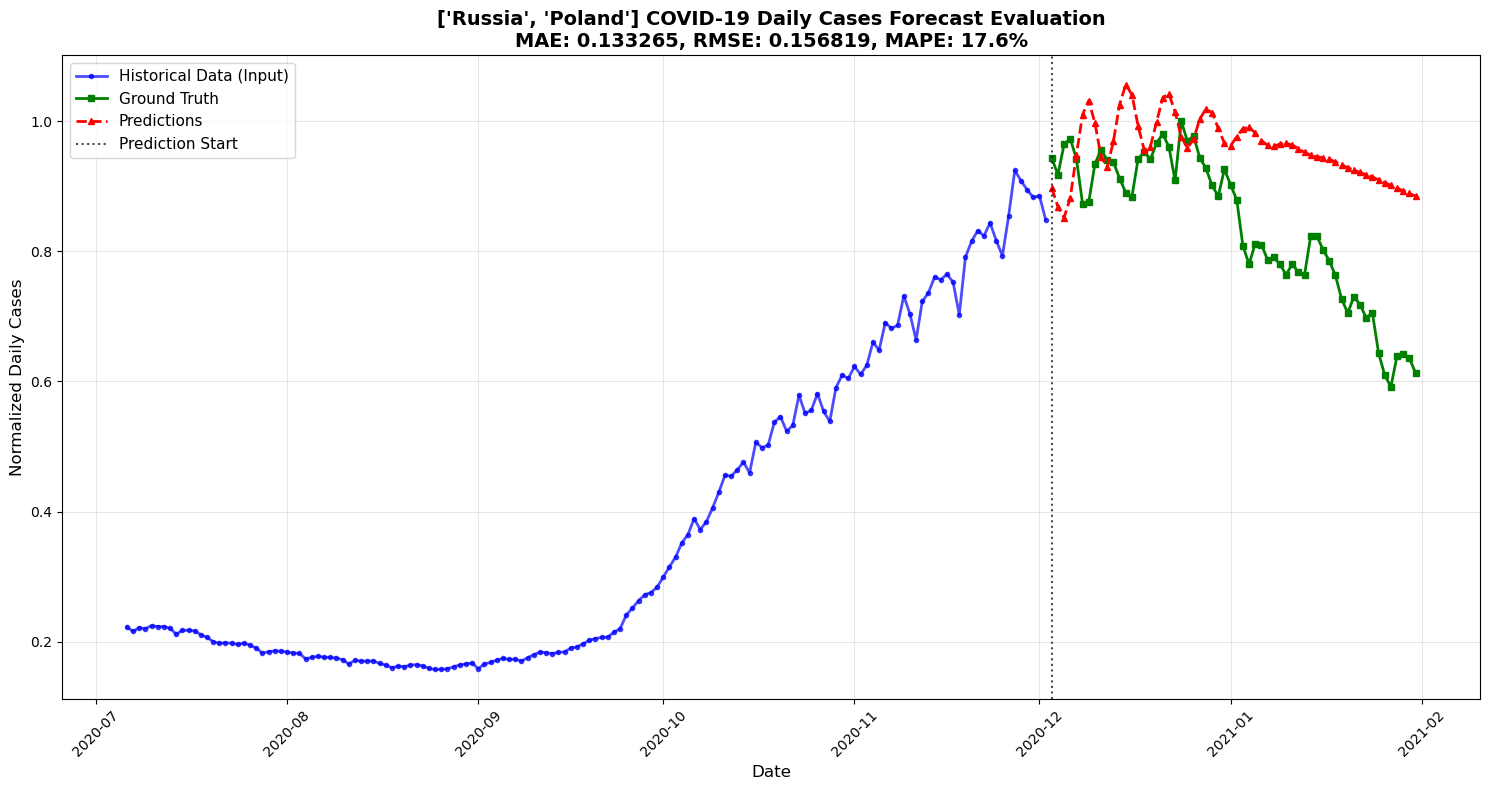


🔍 Evaluating model for Poland...

🎯 MODEL EVALUATION
🔄 Preparing evaluation data for Poland...
✅ Poland data extracted: 376 data points
✅ Data prepared: input shape (150, 3), target shape (60,)
Prediction shape: (60,)   (should be: (60,))
Ground truth  shape: (60,)   (is: (60,))

📈 Evaluation Metrics for ['Russia', 'Poland']:
   MAE: 0.071268
   RMSE: 0.086843
   MAPE: 35.96%


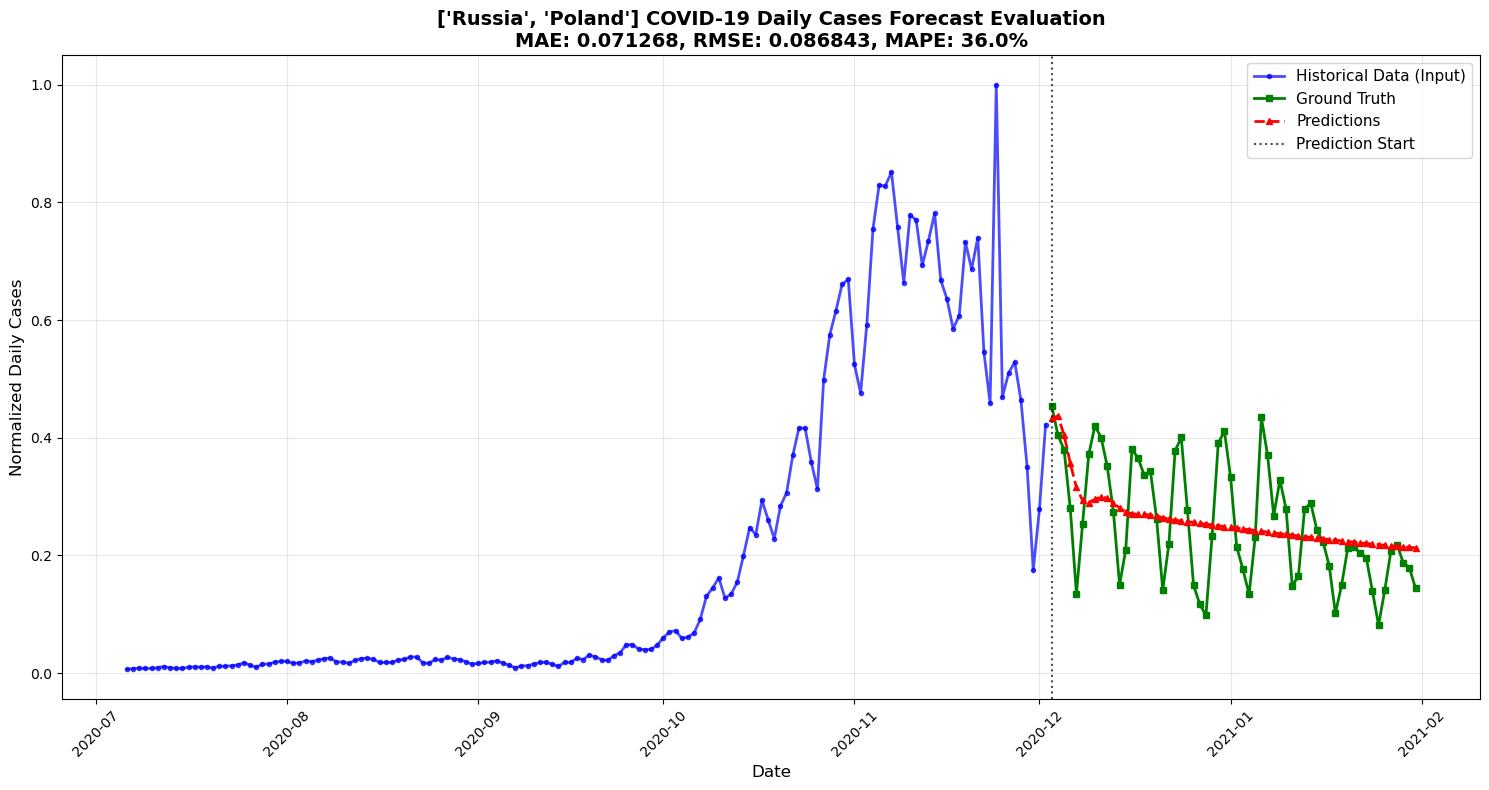

In [44]:
def prepare_evaluation_data(df: pd.DataFrame, country: str, target_column: str, window: int, horizon: int):
    """
    Prepare data for model evaluation.
    
    Args:
        df (pd.DataFrame): Input dataframe
        country (str): Country for evaluation
        target_column (str): Target variable column
        window (int): Input sequence length
        horizon (int): Prediction horizon
    
    Returns:
        tuple: Prepared data for evaluation
    """
    print(f"🔄 Preparing evaluation data for {country}...")
    
    # Extract country data
    dates, _, normalized_series = extract_country_data(df, country, target_column)
    
    # Compute features
    hp_cycle, hp_trend, cf_cycle = compute_time_series_features(normalized_series)
    
    # Create feature matrix
    feature_matrix = create_feature_matrix(normalized_series, hp_trend, cf_cycle)

    # Prepare input and target sequences
    if len(feature_matrix) < window + horizon:
        raise ValueError(f"Insufficient data: need {window + horizon}, got {len(feature_matrix)}")
    
    # Take the last available window for prediction
    start_idx = len(feature_matrix) - window - horizon
    end_input_idx = start_idx + window
    end_target_idx = end_input_idx + horizon
    
    X_input = np.array(feature_matrix[start_idx:end_input_idx])  # (window, 3)
    y_truth = normalized_series[end_input_idx:end_target_idx]   # (horizon,)
    
    # Corresponding dates
    dates_input = pd.to_datetime(dates[start_idx:end_input_idx])
    dates_truth = pd.to_datetime(dates[end_input_idx:end_target_idx])
    ts_input = normalized_series[start_idx:end_input_idx]
    
    print(f"✅ Data prepared: input shape {X_input.shape}, target shape {y_truth.shape}")
    
    return X_input, y_truth, dates_input, dates_truth, ts_input

def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Calculate evaluation metrics.
    
    Args:
        y_true (np.ndarray): Ground truth values
        y_pred (np.ndarray): Predicted values
    
    Returns:
        dict: Dictionary of calculated metrics
    """
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

def plot_prediction_results(dates_input, ts_input, dates_truth, y_truth, y_pred, 
                          country: str, metrics: dict):
    """
    Plot prediction results with evaluation metrics.
    
    Args:
        dates_input: Input sequence dates
        ts_input: Input sequence values
        dates_truth: Truth sequence dates  
        y_truth: Ground truth values
        y_pred: Predicted values
        country (str): Country name
        metrics (dict): Evaluation metrics
    """
    plt.figure(figsize=(15, 8))
    
    # Plot input sequence for context
    plt.plot(dates_input, ts_input, 'b-', alpha=0.7, linewidth=2, 
             label='Historical Data (Input)', marker='o', markersize=3)
    
    # Plot ground truth
    plt.plot(dates_truth, y_truth, 'g-', linewidth=2, 
             label='Ground Truth', marker='s', markersize=4)
    
    # Plot predictions
    plt.plot(dates_truth, y_pred, 'r--', linewidth=2, 
             label='Predictions', marker='^', markersize=4)
    
    # Add vertical line at prediction start
    plt.axvline(
        x=dates_truth[0],
        color='black',
        linestyle=':',
        alpha=0.7,
        label='Prediction Start'
    )
    
    # Formatting
    title = f'{country} COVID-19 Daily Cases Forecast Evaluation\n'
    title += f"MAE: {metrics['MAE']:.6f}, RMSE: {metrics['RMSE']:.6f}, MAPE: {metrics['MAPE']:.1f}%"
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Daily Cases', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=VIZ_CONFIG['grid_alpha'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(country: str):
    """
    Complete model evaluation pipeline.
    """
    print("\n" + "="*50)
    print("🎯 MODEL EVALUATION")
    print("="*50)
    
    # ─── Prepare evaluation data ───────────────────────────────────────────────
    X_input, y_truth, dates_input, dates_truth, ts_input = prepare_evaluation_data(
        df, 
        country, 
        DATA_CONFIG['target_column'],
        MODEL_CONFIG['window'],
        MODEL_CONFIG['horizon']
    )
    
    # ─── Load trained PyTorch model from MLflow ────────────────────────────────
    if run_id is None:
        raise ValueError("run_id is not defined in MLFLOW_CONFIG. Please set run_id to the MLflow run you wish to load.")
    
    model_uri = f"runs:/{run_id}/model"
    model = mlflow.pytorch.load_model(model_uri)
    model.eval()
    device = next(model.parameters()).device
    
    # ─── Convert X_input to tensor, then unsqueeze to add batch dimension ─────
    # X_input originally: (window, 3)  →  we need (window, batch=1, 3)
    if isinstance(X_input, np.ndarray):
        X_input = torch.from_numpy(X_input).float()
    X_input = X_input.unsqueeze(1).to(device)  # now shape is (seq_len, 1, input_features)
    
    # ─── Make prediction ─────────────────────────────────────────────────────
    horizon = MODEL_CONFIG['horizon']
    with torch.inference_mode():
        # model.predict expects a 3-D tensor: (seq_len, batch, input_size)
        y_pred_tensor = model.predict(X_input, horizon=horizon)
    
    # ─── Convert predictions back to CPU/NumPy ────────────────────────────────
    # If y_pred_tensor was (horizon, batch, output_size), squeezing batch=1 gives (horizon,)
    y_pred = y_pred_tensor.cpu().squeeze(dim=1).squeeze(dim=-1).numpy()
    #   └─ squeeze dim=1 removes batch dimension
    #         └─ squeeze dim=-1 removes the output_features=1 dimension
    
    print(f"Prediction shape: {y_pred.shape}   (should be: ({horizon},))")
    print(f"Ground truth  shape: {y_truth.shape}   (is: ({horizon},))")
    
    # ─── Calculate metrics ────────────────────────────────────────────────────
    metrics = calculate_metrics(y_truth, y_pred)
    
    # ─── Display metrics ──────────────────────────────────────────────────────
    print(f"\n📈 Evaluation Metrics for {DATA_CONFIG['target_country']}:")
    for metric, value in metrics.items():
        if metric == 'MAPE':
            print(f"   {metric}: {value:.2f}%")
        else:
            print(f"   {metric}: {value:.6f}")
    
    # ─── Plot results ──────────────────────────────────────────────────────────
    plot_prediction_results(
        dates_input,
        ts_input,
        dates_truth,
        y_truth,
        y_pred,
        DATA_CONFIG['target_country'],
        metrics
    )

# Run evaluation
for country in DATA_CONFIG['target_country']:
    print(f"\n🔍 Evaluating model for {country}...")
    
    evaluate_model_performance(country=country)